In [1]:
import os
import os.path as osp

from datetime import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.multiprocessing

from torch_geometric.data import Data
import torch_geometric
import networkx as nx


from sklearn.model_selection import train_test_split
import joblib

from GNNDataset import GNNDataset
from ClusterDataset import ClusterDataset
from ClusterDatasetBuilder import ClusterDatasetBuilder
from train_transformer import *
from data_statistics import *
from GNN_TrackLinkingNet import EarlyStopping, weight_init

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

In [2]:
# CUDA Setup
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}, number of devices: {torch.cuda.device_count()}")

Using device: cuda:0, number of devices: 1


In [3]:
input_length = 60
max_seq_length = 60
batch_size = 64
converter = Lang(0)

In [4]:
torch.multiprocessing.set_start_method('spawn')

In [5]:
# Load the dataset
base_folder = "/home/jovyan"
model_folder = osp.join(base_folder, "model")
data_folder_training = osp.join(base_folder, "graph_data/processed")
store_folder_training = osp.join(base_folder, "graph_data_trans")
data_folder_test = osp.join(base_folder, "graph_data_test/processed")
store_folder_test = osp.join(base_folder, "graph_data_trans_test")

scaler = joblib.load(osp.join(base_folder, "graph_data/scaler.joblib"))
scale = torch.tensor(scaler.scale_).to(device)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MaxAbsScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
testBuilder = ClusterDatasetBuilder(store_folder_test, data_folder_test, input_length=input_length)

if not testBuilder.metadata_exists():
    testBuilder.generate(24, device)

In [7]:
trainBuilder = ClusterDatasetBuilder(store_folder_training, data_folder_training, input_length=input_length)

if not trainBuilder.metadata_exists():
    trainBuilder.generate(24, device)

In [8]:
dataset_training = ClusterDataset(store_folder_training, input_length=input_length, scale=scale, output_group=False)
dataset_test = ClusterDataset(store_folder_test, input_length=input_length, scale=scale, output_group=False)

Done
Done


In [9]:
epochs = 100
num_heads = 2
num_layers = 3
d_model = 128
d_ff = 256
dropout = 0.2
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)
max_nodes = max(dataset_test.max_nodes, dataset_training.max_nodes)
vocab_size = max_nodes + 4


# Model, loss, and optimizer
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout)
weight_init(model)
criterion = Loss(converter, vocab_size, device=device)

In [10]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.parallel.DistributedDataParallel(model)
    
model.to(device)

Transformer(
  (encoder_embedding): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (decoder_embedding): Embedding(170, 128)
  (tgt_positional_encoding): PositionalEncoding()
  (src_positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
 

In [11]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [16]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Drop Step Size over time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
early_stopping = EarlyStopping(patience=5, delta=-0.02)

In [17]:
#Load Weights if needed
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [18]:
train_loss_hist = []
val_loss_hist = []

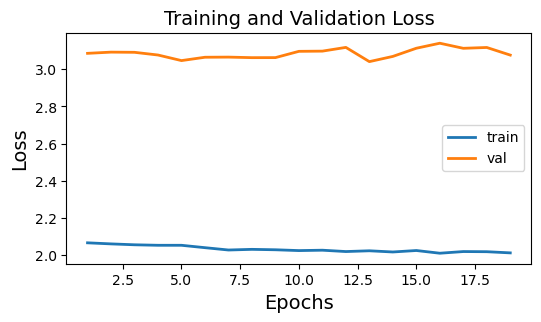

Epoch: 1


Training Epoch 1: 100%|██████████| 57/57 [00:06<00:00,  9.33it/s]


Training loss: 2.0671527490281223


Validation Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 11.59it/s]

Validation loss: 3.0850629125322615


Epoch 1, LR: 1e-05
Epoch: 2


Training Epoch 2: 100%|██████████| 57/57 [00:06<00:00,  9.43it/s]


Training loss: 2.061382475652193


Validation Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 11.58it/s]

Validation loss: 3.0915609768458774


Epoch 2, LR: 1e-05
Epoch: 3


Training Epoch 3: 100%|██████████| 57/57 [00:05<00:00,  9.59it/s]


Training loss: 2.0565769463254693


Validation Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 11.71it/s]

Validation loss: 3.090559482574463


Epoch 3, LR: 1e-05
Epoch: 4


Training Epoch 4: 100%|██████████| 57/57 [00:06<00:00,  9.45it/s]


Training loss: 2.053905484969156


Validation Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 11.64it/s]

Validation loss: 3.0760644504002164


Epoch 4, LR: 1e-05
Epoch: 5


Training Epoch 5: 100%|██████████| 57/57 [00:05<00:00,  9.57it/s]


Training loss: 2.0538887893944455


Validation Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 11.50it/s]

Validation loss: 3.046112367085048


Epoch 5, LR: 5e-06
Epoch: 6


Training Epoch 6: 100%|██████████| 57/57 [00:06<00:00,  9.29it/s]


Training loss: 2.0410531759262085


Validation Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 11.56it/s]

Validation loss: 3.0640576226370677


Epoch 6, LR: 5e-06
Epoch: 7


Training Epoch 7: 100%|██████████| 57/57 [00:05<00:00,  9.60it/s]


Training loss: 2.028522102456344


Validation Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 11.45it/s]

Validation loss: 3.064795289720808


Epoch 7, LR: 5e-06
Epoch: 8


Training Epoch 8: 100%|██████████| 57/57 [00:06<00:00,  9.44it/s]


Training loss: 2.0320474055775426


Validation Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]

Validation loss: 3.0618906361716136


Epoch 8, LR: 5e-06
Epoch: 9


Training Epoch 9: 100%|██████████| 57/57 [00:06<00:00,  9.43it/s]


Training loss: 2.0297902508785852


Validation Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 11.78it/s]

Validation loss: 3.062094415937151


Epoch 9, LR: 5e-06
Epoch: 10


Training Epoch 10: 100%|██████████| 57/57 [00:05<00:00,  9.59it/s]


Training loss: 2.0254156547680235


Validation Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 11.62it/s]

Validation loss: 3.0958098002842496


Epoch 10, LR: 2.5e-06
Epoch: 11


Training Epoch 11: 100%|██████████| 57/57 [00:05<00:00,  9.60it/s]


Training loss: 2.027465036040858


Validation Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 11.49it/s]

Validation loss: 3.096930367606027


Epoch 11, LR: 2.5e-06
Epoch: 12


Training Epoch 12: 100%|██████████| 57/57 [00:05<00:00,  9.55it/s]


Training loss: 2.020234271099693


Validation Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 11.30it/s]


Validation loss: 3.116990872791835
Epoch 12, LR: 2.5e-06
Epoch: 13


Training Epoch 13: 100%|██████████| 57/57 [00:06<00:00,  9.14it/s]


Training loss: 2.024341524693004


Validation Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 10.43it/s]

Validation loss: 3.0405405930110385


Epoch 13, LR: 2.5e-06
Epoch: 14


Training Epoch 14: 100%|██████████| 57/57 [00:06<00:00,  9.46it/s]


Training loss: 2.017917118574444


Validation Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 11.62it/s]

Validation loss: 3.0685485771724155


Epoch 14, LR: 2.5e-06
Epoch: 15


Training Epoch 15: 100%|██████████| 57/57 [00:06<00:00,  9.43it/s]


Training loss: 2.025809538991828


Validation Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 11.51it/s]

Validation loss: 3.112435817718506


Epoch 15, LR: 1.25e-06
Epoch: 16


Training Epoch 16: 100%|██████████| 57/57 [00:06<00:00,  9.45it/s]


Training loss: 2.0112581148482205


Validation Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 11.50it/s]

Validation loss: 3.1394154684884206


Epoch 16, LR: 1.25e-06
Epoch: 17


Training Epoch 17: 100%|██████████| 57/57 [00:06<00:00,  9.43it/s]


Training loss: 2.02020890252632


Validation Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 11.55it/s]

Validation loss: 3.1121180057525635


Epoch 17, LR: 1.25e-06
Epoch: 18


Training Epoch 18: 100%|██████████| 57/57 [00:06<00:00,  9.45it/s]


Training loss: 2.01938888064602


Validation Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 11.53it/s]

Validation loss: 3.116561378751482


Epoch 18, LR: 1.25e-06
Early stopping after 19 epochs with best score -3.0405405930110385
Epoch: 19


Training Epoch 19: 100%|██████████| 57/57 [00:06<00:00,  9.45it/s]


Training loss: 2.0131082890326515


Validation Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 11.63it/s]

Validation loss: 3.0756591388157437


Epoch 19, LR: 1.25e-06
Early stopping after 20 epochs with best score -3.0405405930110385
Epoch: 20


Training Epoch 20:  72%|███████▏  | 41/57 [00:04<00:01,  9.15it/s]


KeyboardInterrupt: 

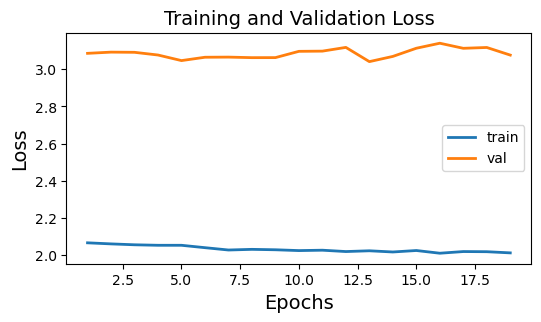

In [19]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# Optionally introduce gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()

# Training loop
for epoch in range(1, 101):
    print(f'Epoch: {epoch}')
    
    loss = train(model, optimizer, train_dl, epoch, criterion, vocab_size, device=device)
    print(f"Training loss: {loss}")
    train_loss_hist.append(loss)
    
    val_loss = test(model, test_dl, epoch, criterion, vocab_size, device=device)
    val_loss_hist.append(val_loss)
    print(f"Validation loss: {val_loss}")
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss, n=0)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch}, LR: {scheduler.get_last_lr()[0]}")
    
    early_stopping(model, val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping after {epoch+1} epochs with best score {early_stopping.best_score}")
        early_stopping.load_best_model(model)
#         break

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
date = f"{datetime.now():%Y-%m-%d-%H}:00"
save_model(model, epoch, optimizer, train_loss_hist, val_loss_hist, model_folder, f"tranformer_date_{date}.pt")

## Test Full Event

In [ ]:
from EventGrouping import EventGrouping

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load(osp.join(model_folder, "tranformer_date_2025-06-02-16:00.pt"), weights_only=True)
model.load_state_dict(weights["model_state_dict"])

In [ ]:
components = dataset_training.get(0)
print(len(components))

In [ ]:
runner = EventGrouping(model, seq_length=input_length)

nTrackster = 0
for component in components:
    max_comp_t = int(torch.max(component["x"]).item())
    if max_comp_t > nTrackster:
        nTrackster = max_comp_t
  
group = 0
edges = np.full(nTrackster, -1)

    
for component in components:
    converter = Lang(trackster_list=component["lang"])
    print("Goal", component["seq"], converter.word2index[component["root"]])
    res = runner(component)[-1]
    print(runner(component)[-1])
    
    new_groups = converter.seq2y(res.cpu().numpy(), nodes=nTrackster, start_group=group)
    print(np.array(range(new_groups.shape[0]))[new_groups >= 0])
    edges = np.maximum(edges, converter.seq2y(res.cpu().numpy(), nodes=nTrackster, start_group=group))
    print(np.max(edges))
    group = np.max(edges) + 1

In [ ]:
edges[edges>=0]

## Random Tests

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_date_2025-06-02-16:00.pt", weights_only=True)
model.load_state_dict(weights["model_state_dict"])

In [ ]:
components = dataset_training.get(0)
components[0]["lang"]

In [ ]:
dataset_training.__getitem__(0)

In [ ]:
num_nodes = components[0]["nTrackster"]
converter = Lang(trackster_list=components[0]["lang"])
sample_seq = converter.starting_seq(components[0]["root"], input_length).to(device)
print(sample_seq)

X = components[0]["x"].float()
X /= scale
X = F.pad(X, pad=(0, 0, max_nodes - num_nodes, 0), value=converter.word2index["<PAD>"])
X = X[:, list(map(dataset_test.node_feature_dict.get, dataset_test.model_feature_keys))]

predictions = model(torch.unsqueeze(X, dim=0), torch.unsqueeze(sample_seq, dim=0))
predicted_index = torch.argsort(-predictions[0, -1, :num_nodes], dim=0)
print(predicted_index)

In [ ]:
targets[targets[:, -1] != -4, :]

In [ ]:
targets[mask].shape[0]/3

In [ ]:
opts = dataset_training.__getitem__(0)[1]
opts = torch.roll(opts, -1, dims=0)
opts[-1] = 5
opts

In [ ]:
out_mask = opts != -4
opts[out_mask].shape[0]

In [ ]:
targets = torch.reshape(targets[mask], (int(targets[mask].shape[0]/3), 3))

In [ ]:
targets[0, :]